# The Cannon Workshop
#### Import important python packages

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

from IPython.display import clear_output

import thecannon as tc

#### Useful functions we'll use throughout the workshop

In [321]:
def convert_labels_into_training_set_labels(list_of_all_labels, labels):
    """
    Create a training set labels table with the specified labels.

    Args:
        list_of_all_labels (list or pandas.DataFrame): A list or pandas DataFrame containing all possible labels.
        labels (list): A list of labels (str) to include in the training set.

    Returns:
        training_set_labels (astropy.Table): An astropy Table containing only the specified labels.
    """
    trainingset = Table.from_pandas(list_of_all_labels)
    
    training_set_labels = Table()
    for label in labels:
        training_set_labels[label] = trainingset[label]
        
    return training_set_labels

def plot_1to1(test_labels,original_labels,model_labels):
    """
    Create a 1-to-1 scatter plot comparing predicted and expected labels.

    Args:
        test_labels (numpy.ndarray): Array of predicted labels.
        original_labels (pandas.DataFrame): DataFrame of original labels.
        model_labels (list): List of label names to be plotted.

    Returns:
        None - displays a plot
    """
    ncols = 2
    nrows = int(np.ceil(len(model_labels)/2))
    
    fig, ax = plt.subplots(nrows,ncols,figsize=(5*ncols,5*nrows))
    
    for idx,axes in enumerate(ax.flatten()):
        if idx==len(model_labels):
            break
        else:
            axes.scatter(original_labels[model_labels[idx]],test_labels[:,idx],s=10)
            buffer = (max(test_labels[:,idx])-min(test_labels[:,idx]))/3
            axes.set_xlim(min(test_labels[:,idx])-buffer,max(test_labels[:,idx])+buffer)
            axes.set_ylim(min(test_labels[:,idx])-buffer,max(test_labels[:,idx])+buffer)
            axes.plot([0, 1], [0, 1], transform=axes.transAxes,color='k',ls='dashed',lw=1)
            axes.set_xlabel(f"Expected {model_labels[idx]}")
            axes.set_ylabel(f"Cannon Predicted {model_labels[idx]}")
            
def plot_coefficient(term,model,model_labels,linelist=line_list,xlim=None):
    """
    Plot the coefficient of a specific term in the model.

    Args:
        term (str): The term for which the coefficient will be plotted.
        model (object): The Cannon model containing the coefficient values.
        model_labels (list): List of label names in the model.
        linelist (pandas.DataFrame, optional): DataFrame containing a list of wavelengths and species names.
                                               Defaults to line_list.
        xlim (tuple, optional): The limits of the x-axis. Defaults to None.

    Returns:
        None - displays a plot
    """
    theta_idx = model_labels.index(term)+1
    
    fig, ax = plt.subplots(2,1,figsize=(15,7),sharex=True)
    plt.subplots_adjust(hspace=0.05)
    
    ax[0].plot(model.dispersion,model.theta[:,0])
    ax[0].set_ylabel('Stellar Flux',fontsize=12)
    ax[1].plot(model.dispersion,model.theta[:,theta_idx],label=term)
    ax[1].set_ylabel(term+' coefficient',fontsize=12)
    ax[1].set_xlabel(r"Wavelength [$\AA$]",fontsize=12)
    ax[0].set_ylim(0,1.3)
    
    if xlim==None:
        subset = linelist[(linelist['Wavelength']>=model.dispersion.min()) & (linelist['Wavelength']<=model.dispersion.max())]
        xlim = ax[0].get_xlim()
    else:
        subset = linelist[(linelist['Wavelength']>=min(xlim)) & (linelist['Wavelength']<=max(xlim))]
        ax[0].set_xlim(xlim)
        
    yshift = (max(xlim)-min(xlim))/200
    for i in subset.index:
        ax[0].arrow(x=subset['Wavelength'][i],y=1.1,dx=0,dy=-0.08)
        ax[0].text(x=subset['Wavelength'][i]-yshift,y=1.14,s=subset['Species'][i].split()[0],rotation=90)

#### Load data necessary for The Cannon

In [389]:
# This loads in the labels we'll use to train The Cannon
all_labels = pd.read_csv('./labels.csv')

# This loads in the data we're going to use
flux_all = []
errs_all = []

for i in all_labels['sobject_id'].values:
    with fits.open(f"./data/{str(i)}.fits") as data:
        dispersion = data[1].data
        flux_all.append(data[0].data)
        errs_all.append(data[2].data)
    
flux_all = np.array(flux_all)
errs_all = np.array(errs_all)
ivar_all = 1/errs_all**2

# This is a list of atomic lines identified in the spectra we're analysing
line_list = pd.read_csv('./lines.csv')

## Separating the training objects from the test objects

In [390]:
# Generate a list of 100 random sobject_id entries with no repeats
training_set_stars = np.random.choice(all_labels['sobject_id'],size=50,replace=False)


# Separate the all_labels DataFrame into training and test sets based on the above list
training_set = all_labels[all_labels['sobject_id'].isin(training_set_stars)]
training_idx = training_set.index

test_set = all_labels[~all_labels['sobject_id'].isin(training_set_stars)]
test_idx = test_set.index


# Separate training/test flux and ivars
training_flux = flux_all[training_idx]
training_ivar = ivar_all[training_idx]

test_flux = flux_all[test_idx]
test_ivar = ivar_all[test_idx]

## Setting up The Cannon model
What we need:
* training set labels
* training set flux
* training set invariances
* a vectoriser to declare the polynomial function used to predict each flux pixel (and the subsequent order of that polynomial)
* the dispersion (optional)

In [391]:
# Declare the order of your polynomial
order = 2

# Which labels are we going to use in our model?
model_labels = ['teff','logg','fe_h','alpha_fe']

# Set up a model file name based on those labels
model_file = 'model_order'+str(order)+'_'+"_".join(model_labels)

# Set up the training set labels Table
training_set_labels = convert_labels_into_training_set_labels(training_set,model_labels)

# Declare The Cannon model
model = tc.CannonModel(training_set_labels=training_set_labels,
                       training_set_flux=training_flux,
                       training_set_ivar=training_ivar,
                       vectorizer=tc.vectorizer.PolynomialVectorizer(model_labels,order),
                       dispersion=dispersion)

## Training The Cannon model

In [392]:
if not model.is_trained:
    print("Training The Cannon...")
    theta, s2, train_metadata = model.train()
    
    # Save the result
    model.write(model_file+'.model', overwrite=True, include_training_set_spectra=True)
    clear_output(wait=True)
    print("Finished training...")
else:
    print("The Cannon is already trained!")

Finished training...


## Testing The Cannon model

In [393]:
print("Testing The Cannon...")
test_labels, cov, test_metadata = model.test(flux=test_flux,ivar=test_ivar)
print("Done!")

stty: 2023-05-16 15:50:07,643 [DEBUG] Couldn't get screen size. Progressbar may look odd.
stdin isn't a terminal
2023-05-16 15:50:07,657 [INFO] Running test step on 237 spectra


Testing The Cannon...
[======================================================================================================================] 100% (14s)                              
Done!


## Let's look at the results!
### Label transfer
Let's see how well the test step went!

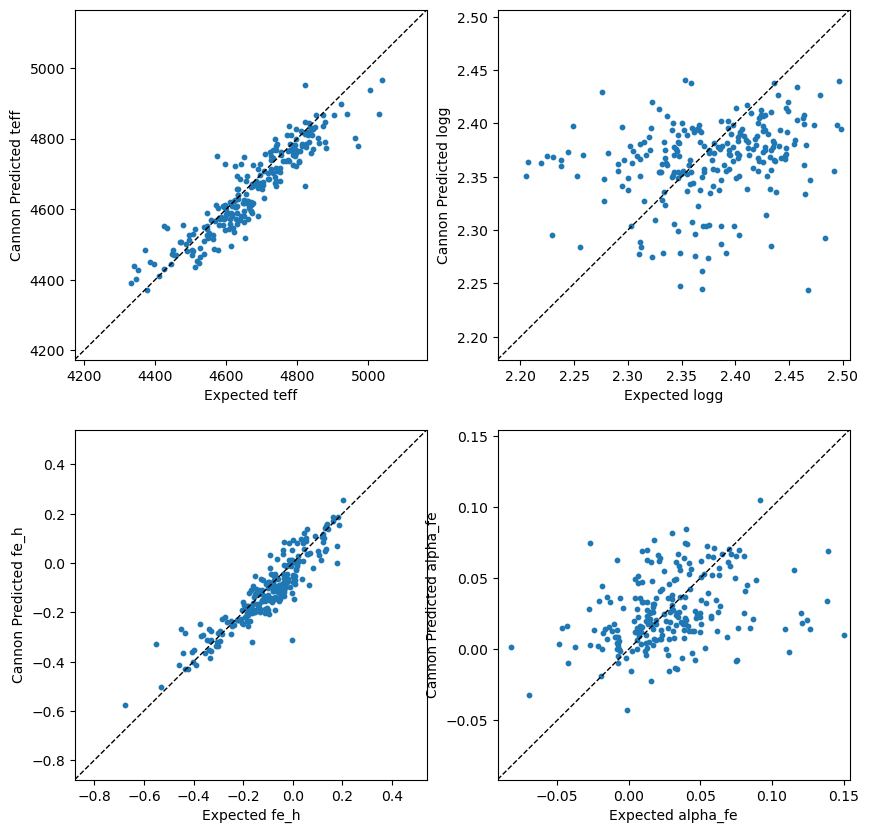

In [394]:
plot_1to1(test_labels,test_set,model_labels)

### Coefficients of the model
Let's have a closer look at the model coefficients...

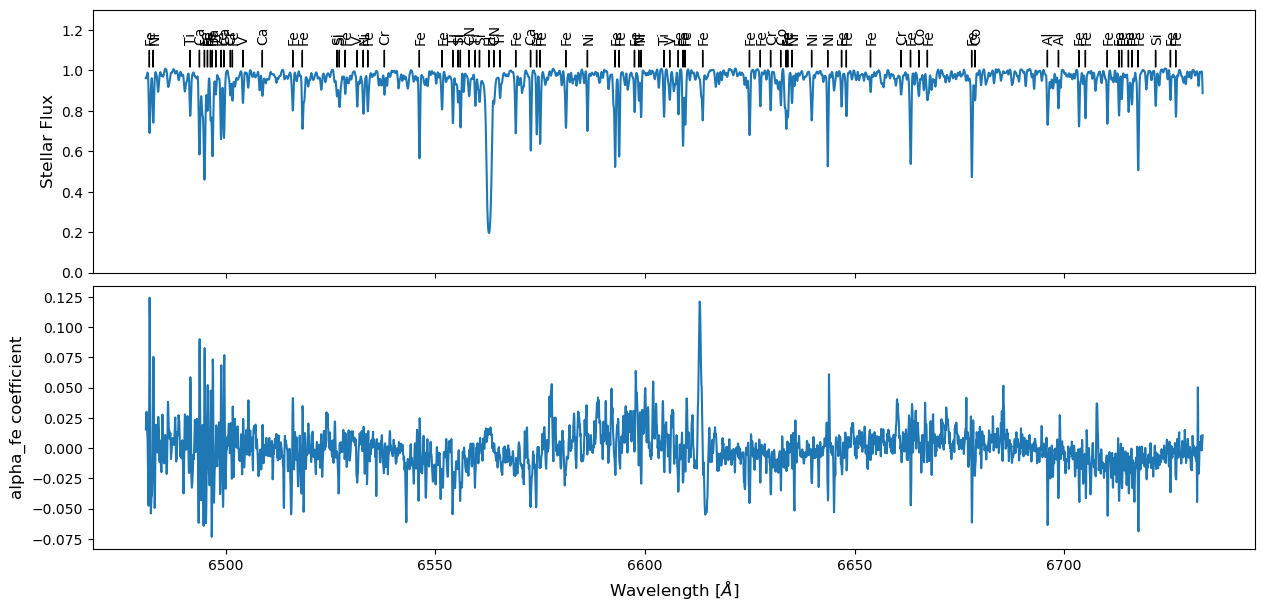

In [399]:
plot_coefficient('alpha_fe',model,model_labels)